In [4]:
import re
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

## Same as previous notebook but with stenos from Jan 2022 till Oct 2023

## Helpers

In [5]:
def get_pattern_elem(text, pattern='[0-9][0-9]:[0-9][0-9]', alternative_pattern='[0-9][0-9]\.[0-9][0-9]'):
    """get element from regex pattern. used to get time information from text
    -INPUT:
        -text: str of text where to search pattern
        -pattern: str of regex oattern
        -alternative_pattern: str of alternative regex pattern if first pattern didn't return response
    -OUTPUT:
        - str of matched pattern where . is replaced with :"""
    match=re.search(pattern,text)
    if match is None:
        match=re.search(alternative_pattern,text) 
        if match is None:
            return
    span=match.span()
    return text[span[0]:span[1]].replace('.',':')

In [6]:
def stenos2df(stenos):
    '''Parse stenos to pandas DataFrame
    NB! this function adds steno link to all of the segments!
    -INPUT:
        -stenos: dict of stenos
    -OUTPUT:
        -pd.DataFrame of stenos'''
    stenos_flat=[]
    for steno_url in stenos.keys():
        data_steno=stenos[steno_url]['talk']
        #[row.update({'link_steno':steno_url}) for row in data_steno]
        stenos_flat.extend(data_steno)
    return pd.DataFrame(stenos_flat)

## Data

In [7]:
with open('data/raw/stenos_from_links2022.json') as f:
    data=json.load(f)

## Format to df

In [8]:
df=stenos2df(data)
df.shape

(47236, 7)

In [9]:
df.head()

,heading,speaker,link_video,link_steno,index_pk,index_snd,text
0,13:58 Istungi rakendamine,14:00\n\n \n\n ...,https://www.youtube.com/watch?v=xker_lBOjl8&t=0,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377973,
1,13:58 Istungi rakendamine,14:00\n\n \n\n ...,https://www.youtube.com/watch?v=xker_lBOjl8&t=27,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377975,
2,13:58 Istungi rakendamine,14:01\n\n \n\n ...,https://www.youtube.com/watch?v=xker_lBOjl8&t=96,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377972,
3,13:58 Istungi rakendamine,14:01\n\n \n\n ...,https://www.youtube.com/watch?v=xker_lBOjl8&t=105,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377976,None
4,13:58 Istungi rakendamine,14:02\n\n \n\n ...,https://www.youtube.com/watch?v=xker_lBOjl8&t=136,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377974,


## Get time

In [10]:
def clean_speaker(text):
    """helper func to clean speaker name
    -INPUT:
        -text: str of speaker name
    -OUTPUT:
        -cleaner text"""
    text=text.replace('\n','').replace('<strong>', '').replace('</strong>', '')
    text= re.sub('\d\d:\d\d','', text)
    text=text.strip()
    text=' '.join(text.split())
    return text

def time_from_speaker(text, return_h=True):
    """get time information from speaker name text
    -INPUT:
        -text: str of speaker name
        -return_h: bool if true returns hour infomration otherwise minutes
    -OUTPUT:
        str of tme information"""
    time=re.findall('\d\d:\d\d',text)
    hour, minutes = time[0].split(':')
    if return_h:
        return hour
    return minutes

def has_time(text):
    """check if text contains time information"""
    return bool(re.search('\d\d:\d\d', text))

In [11]:
df['year']=df.link_steno.apply(lambda x: x.split('/')[-1][:4])
df['month']=df.link_steno.apply(lambda x: x.split('/')[-1][4:6])
df['day']=df.link_steno.apply(lambda x: x.split('/')[-1][6:8])
df['time']=df.heading.apply(lambda x: get_pattern_elem(x))
speaker_has_time=df.speaker.apply(has_time)
speaker_times=df.speaker.apply(get_pattern_elem)
df['time']=np.where(speaker_has_time, speaker_times, df.time)
df['seconds_from_start']=df.link_video.apply(lambda x: str(x).split('&t=')[-1])
df['video_link_wo_time']=df.link_video.apply(lambda x: str(x).split('&t=')[0])
df['speaker']=df.speaker.apply(clean_speaker)
df.head()

,heading,speaker,link_video,link_steno,index_pk,index_snd,text,year,month,day,time,seconds_from_start,video_link_wo_time
0,13:58 Istungi rakendamine,Aseesimees Martin Helme,https://www.youtube.com/watch?v=xker_lBOjl8&t=0,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377973,,2022,12,14,14:00,0,https://www.youtube.com/watch?v=xker_lBOjl8
1,13:58 Istungi rakendamine,Heiki Kranich,https://www.youtube.com/watch?v=xker_lBOjl8&t=27,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377975,,2022,12,14,14:00,27,https://www.youtube.com/watch?v=xker_lBOjl8
2,13:58 Istungi rakendamine,Aseesimees Martin Helme,https://www.youtube.com/watch?v=xker_lBOjl8&t=96,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377972,,2022,12,14,14:01,96,https://www.youtube.com/watch?v=xker_lBOjl8
3,13:58 Istungi rakendamine,Kohaloleku kontroll,https://www.youtube.com/watch?v=xker_lBOjl8&t=105,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377976,None,2022,12,14,14:01,105,https://www.youtube.com/watch?v=xker_lBOjl8
4,13:58 Istungi rakendamine,Aseesimees Martin Helme,https://www.youtube.com/watch?v=xker_lBOjl8&t=136,https://stenogrammid.riigikogu.ee/202212141400,PKP-566707,SND-18377974,,2022,12,14,14:02,136,https://www.youtube.com/watch?v=xker_lBOjl8


In [12]:
df.tail()

,heading,speaker,link_video,link_steno,index_pk,index_snd,text,year,month,day,time,seconds_from_start,video_link_wo_time
47231,2.\n 10:15 Jõuluvana,Jaak Juske,https://www.youtube.com/watch?v=Wxpvs5IFpn4&t=...,https://stenogrammid.riigikogu.ee/202212151000,PKP-565151,SND-18354221,See lõppev aasta polnud kerge. / Sõda muutis ...,2022,12,15,10:46,2775,https://www.youtube.com/watch?v=Wxpvs5IFpn4
47232,2.\n 10:15 Jõuluvana,Jõuluvana,https://www.youtube.com/watch?v=Wxpvs5IFpn4&t=...,https://stenogrammid.riigikogu.ee/202212151000,PKP-565151,SND-18354224,"Väga ilus, väga ilus!",2022,12,15,10:47,2841,https://www.youtube.com/watch?v=Wxpvs5IFpn4
47233,2.\n 10:15 Jõuluvana,Toomas Jürgenstein,https://www.youtube.com/watch?v=Wxpvs5IFpn4&t=...,https://stenogrammid.riigikogu.ee/202212151000,PKP-565151,SND-18354189,Head kolleegid! Hea jõuluvana! Enne tegin ma ...,2022,12,15,10:47,2846,https://www.youtube.com/watch?v=Wxpvs5IFpn4
47234,2.\n 10:15 Jõuluvana,Jõuluvana,https://www.youtube.com/watch?v=Wxpvs5IFpn4&t=...,https://stenogrammid.riigikogu.ee/202212151000,PKP-565151,SND-18354182,"Väga ilus, väga ilus. Tublid poisid olete. Pa...",2022,12,15,10:48,2926,https://www.youtube.com/watch?v=Wxpvs5IFpn4
47235,2.\n 10:15 Jõuluvana,Istung lõppes,None,https://stenogrammid.riigikogu.ee/202212151000,PKP-565151,SND-18354210,,2022,12,15,10:52,None,None


In [13]:
df.shape

(47236, 13)

In [14]:
df.index_pk.nunique()

1561

In [15]:
df.index_snd.nunique()

47236

In [16]:
#any missing time from steno start
df[pd.isnull(df.seconds_from_start)].shape

(0, 13)

In [17]:
#nr of unique stenograms
df.link_steno.nunique()

211

In [18]:
#nr of unique videos
df.link_video.nunique(), df.video_link_wo_time.nunique()

(44880, 219)

## Quick overview

<Axes: xlabel='year'>

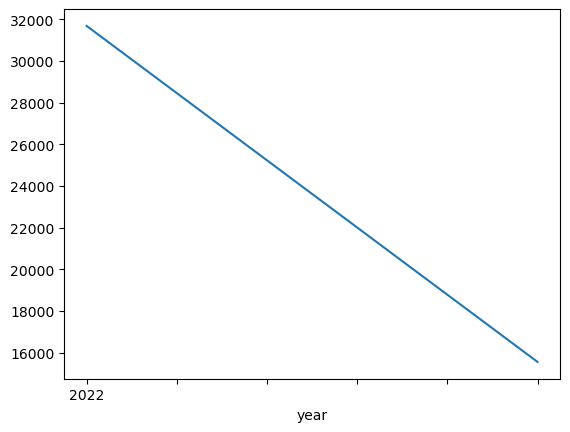

In [19]:
#nr of steno segments per year
df.groupby('year').count()['link_steno'].plot()

<Axes: xlabel='month'>

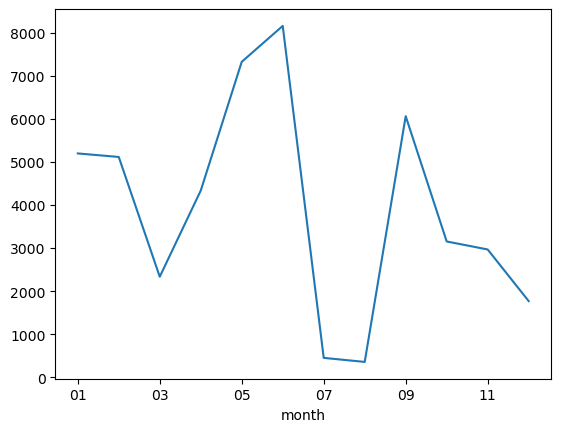

In [20]:
#nr steno segments per month (across all years)
df.groupby('month').count()['link_steno'].plot()

<Axes: xlabel='day'>

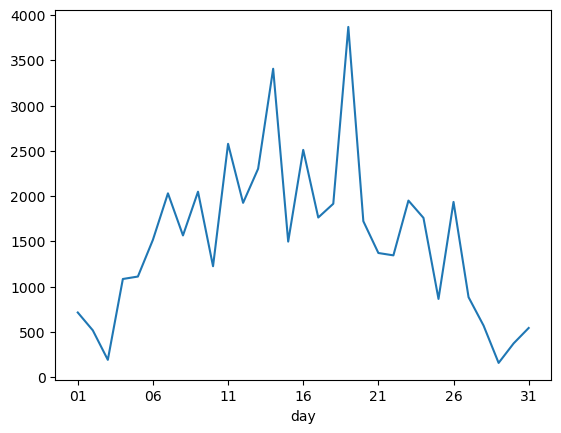

In [21]:
#nr steno segments per day (across years)
df.groupby('day').count()['link_steno'].plot()

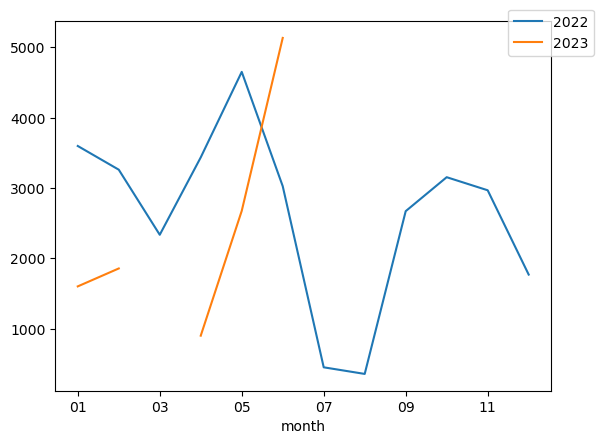

In [22]:
#nr steno segments per month in each year
ax=df.groupby(['month','year']).count()['link_steno'].unstack().plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [23]:
#unique speakers, check if have different capitalization
df.speaker.nunique(), df.speaker.str.lower().nunique()

(253, 253)

<Axes: >

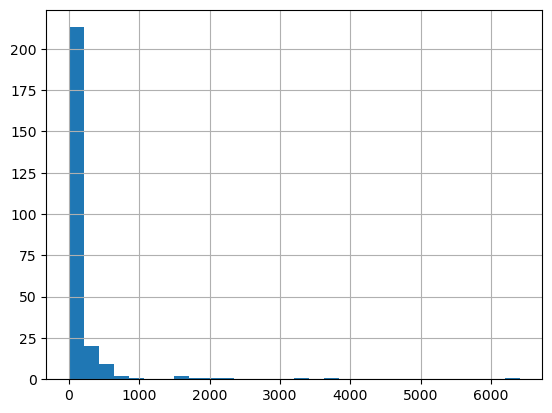

In [24]:
#nr of steno segments per speaker histogram
df.speaker.value_counts().hist(bins=30)

In [25]:
#median and mean steno segments per speaker
df.speaker.value_counts().mean(), df.speaker.value_counts().median()

(186.70355731225297, 50.0)

## Save

In [26]:
df.to_csv('data/interim/stenos2023.csv',index=False)